# Insurance: 360-degree customer view
\[_In case you’re unable to see the Atoti visualizations in GitHub, try viewing the notebook in [nbviewer](https://nbviewer.org/github/atoti/atoti/blob/main/03-use-cases/01-finance/insurance/customer360/02-main-vertica-db.ipynb)._]

Last tested version: <img src="https://img.shields.io/badge/Atoti-v0.8.4-blue">

An insurance company can have multiple contractual relationship with a customer, considering that it has multiple solutions that caters to different risk needs of individuals and corporates.  

Having a customer-centric view of the relationships one has with the insurance company has many advantages, e.g.:
- knowing the customers and their behavior better
- Ability to deliver more personalized experience 
- optimized marketing effort to capitalize opportunities and retaining customers

Legacy systems pose as a challenge for insurance companies to achieve a single customer view.  
With [Atoti](https://www.atoti.io/), we have created a simplified use case of how we can integrate data from different systems into a consolidated view for multidimensional data analytics for insurance industry.  
Mock data schema is being used for demonstrative purpose only.

<div style="text-align: center;" ><a href="https://www.atoti.io/?utm_source=gallery&utm_content=customer360" target="_blank" rel="noopener noreferrer"><img src="https://data.atoti.io/notebooks/banners/Discover-Atoti-now.png" alt="Try Atoti"></a></div>

In [1]:
from datetime import datetime

import atoti as tt
import pandas as pd

## Setting up multidimensional analysis with existing databases  

Out of the box, Atoti supports a wide range of SQL drivers. However, in the event the database does not belong to the supported list, we can always download the corresponding jdbc drivers. In this use case, we'll demonstrate how we can do so by connecting to a [Vertica database](https://www.vertica.com/).  

We [downloaded the vertica jdbc driver](https://www.vertica.com/download/vertica/client-drivers/) to the local directory and configure it under [`extra_jars`](https://docs.atoti.io/latest/lib/atoti.config.session_config.html#atoti.config.session_config.SessionConfig.extra_jars) during the creation of Atoti session.

In [2]:
session = tt.Session(
    extra_jars=["./driver/vertica-jdbc-11.0.0-0.jar"],
    user_content_storage="./content",
    port=9099,
    java_options=["-Xms1G", "-Xmx10G"],
)

### Consolidating policies information

Insurance company A has three different systems storing the below policies:
- Life Insurance
- Property
- Vehicles

We will simplify consolidate the key features of the policy details for these 3 types of policies into a single table in Atoti.  
Atoti is able to read data from different sources such as [CSV, Parquet, Pandas and Spark dataframes](https://www.atoti.io/features/) etc.  
Below, we perform 3 SQL reads from different tables and load the data into the same Atoti table, starting with the Property policies.  
These data will be held in-memory.

Since Atoti does not support Vertica out of the box, we need to define the driver class when we try to perform [`read_sql`](https://docs.atoti.io/latest/lib/atoti.session.html#atoti.session.Session.read_sql).  
Check out the driver classname `com.vertica.jdbc.Driver` and `jdbc URL` for the database from [its website](https://www.vertica.com/docs/9.3.x/HTML/Content/Authoring/ConnectingToVertica/ClientJDBC/CreatingAndConfiguringAConnection.htm).

In [4]:
policy_tbl = session.read_sql(
    """SELECT CUST_ID , PP.POLICY, POLICY_STATUS, 'Property' AS POLICY_TYPE,
    DATE(QUOTE_DATE) AS QUOTE_DATE, DATE(COVER_START) AS COVER_START,
    DATE(LAPSED_DATE) AS LAPSED_DATE, DATE(CANCELLED_DATE) AS CANCELLED_DATE, DATE(MATURITY_DATE) AS MATURITY_DATE,
    PAYMENT_METHOD,PAYMENT_FREQUENCY,SUM_INSURED,OWNERSHIP,PLAN_TYPE,BASIC_PREMIUM, NUM_SUBPOLICY, 'N' as IS_SUB  
    FROM POLICY_PROPERTY PP
    LEFT JOIN (SELECT POLICY, COUNT(DISTINCT(SUB_POLICY)) AS NUM_SUBPOLICY FROM ADDITIONAL_COVERAGE GROUP BY POLICY) ADDONS ON ADDONS.POLICY = PP.POLICY;""",
    url="jdbc:vertica://192.168.56.101:5433/VMart?user=dbadmin&password=password",
    table_name="policy",
    keys=["CUST_ID", "POLICY"],
    driver="com.vertica.jdbc.Driver",
    default_values={"NUM_SUBPOLICY": 0},
)

In [5]:
len(policy_tbl)

136665

Note that in the SQL statement, we have added the `POLICY_TYPE` for each of these read.

In [6]:
policy_tbl.load_sql(
    """select CUST_ID ,POLICY, POLICY_STATUS, 'Vehicle' as POLICY_TYPE,
    DATE(QUOTE_DATE) as QUOTE_DATE, DATE(COVER_START) as COVER_START,
    DATE(LAPSED_DATE) as LAPSED_DATE, DATE(CANCELLED_DATE) as CANCELLED_DATE, DATE(MATURITY_DATE) as MATURITY_DATE,
    PAYMENT_METHOD,PAYMENT_FREQUENCY,SUM_INSURED,OWNERSHIP,PLAN_TYPE,BASIC_PREMIUM, 0 as NUM_SUBPOLICY, 'N' as IS_SUB   
    from policy_vehicle;""",
    url="jdbc:vertica://192.168.56.101:5433/VMart?user=dbadmin&password=password",
    driver="com.vertica.jdbc.Driver",
)

In [7]:
len(policy_tbl)

148243

In [8]:
policy_tbl.head()

POLICY_STATUS POLICY_TYPE QUOTE_DATE COVER_START  \
CUST_ID   POLICY                                                     
C00000002 P187077        Lapsed    Property 1995-12-28  1996-01-01   
C00000021 P009101        Lapsed    Property 1992-12-21  1992-12-22   
C00000038 P211967          Live    Property 1998-12-23  1999-01-12   
C00000076 P116320        Lapsed    Property 2007-09-07  2007-09-12   
C00000085 P109018        Lapsed    Property 1999-12-14  2000-01-02   

                  LAPSED_DATE CANCELLED_DATE MATURITY_DATE PAYMENT_METHOD  \
CUST_ID   POLICY                                                            
C00000002 P187077  2020-01-12     1970-01-01    2026-01-01         PureDD   
C00000021 P009101  2014-01-03     1970-01-01    2022-12-22          NonDD   
C00000038 P211967  1970-01-01     1970-01-01    2029-01-12         PureDD   
C00000076 P116320  2013-12-17     1970-01-01    2037-09-12          NonDD   
C00000085 P109018  2002-08-04     1970-01-01    2030-01-02          NonDD   

                  PAYMENT_FREQUENCY  SUM_INSURED  OWNERSHIP PLAN_TYPE  \
CUST_ID   POLICY                                                        
C00000002 P187077            Annual     165000.0     Tenant         A   
C00000021 P009101            Annual     160000.0   Landlord         B   
C00000038 P211967           3 Years     240000.0  Homeowner         B   
C00000076 P116320           3 Years     210000.0  Homeowner         B   
C00000085 P109018           3 Years     160000.0   Landlord         A   

                   BASIC_PREMIUM  NUM_SUBPOLICY IS_SUB  
CUST_ID   POLICY                                        
C00000002 P187077          58.86              2      N  
C00000021 P009101         115.03              1      N  
C00000038 P211967         293.32              1      N  
C00000076 P116320         293.32              2      N  
C00000085 P109018         150.09              0      N

In [9]:
policy_tbl.load_sql(
    """select CUST_ID ,POLICY, POLICY_STATUS, 'Life insurance' as POLICY_TYPE,
    DATE(QUOTE_DATE) as QUOTE_DATE, DATE(COVER_START) as COVER_START,
    DATE(LAPSED_DATE) as LAPSED_DATE, DATE(CANCELLED_DATE) as CANCELLED_DATE, DATE(MATURITY_DATE) as MATURITY_DATE,
    PAYMENT_METHOD,PAYMENT_FREQUENCY,SUM_INSURED,OWNERSHIP,PLAN_TYPE,BASIC_PREMIUM, 0 as NUM_SUBPOLICY, 'N' as IS_SUB  
    from policy_life;""",
    url="jdbc:vertica://192.168.56.101:5433/VMart?user=dbadmin&password=password",
    driver="com.vertica.jdbc.Driver",
)

In [10]:
len(policy_tbl)

156659

#### Additional coverage 

Some property policies may have added optional coverage by topping up the premiums. The add-ons has its own insured sum.  
In the case of "Family personal accident" add-on for instance, it covers the spouse and up to 3 children.

We craft the SQL such that we can combine the add-ons as sub-policies to the main policy in the same table.

In [11]:
policy_tbl.load_sql(
    """SELECT A.CUST_ID, A.SUB_POLICY as POLICY, P.POLICY_STATUS, P.POLICY_TYPE, DATE(P.QUOTE_DATE) as QUOTE_DATE, DATE(P.COVER_START) as COVER_START, 
    DATE(P.LAPSED_DATE) as LAPSED_DATE, DATE(P.CANCELLED_DATE) as CANCELLED_DATE, DATE(P.MATURITY_DATE) as MATURITY_DATE, 
    P.PAYMENT_METHOD, P.PAYMENT_FREQUENCY, A.ADD_SUM_INSURED AS 'SUM_INSURED', '' AS OWNERSHIP, A.ADD_COVERAGE_TYPE AS 'PLAN_TYPE', 
    CASE WHEN A.RELATION <> 'Insured' THEN 0 ELSE A.PREMIUM END AS 'BASIC_PREMIUM', 
    A.RELATION, 0 as NUM_SUBPOLICY, 'Y' as IS_SUB 
    FROM ADDITIONAL_COVERAGE A 
    LEFT JOIN POLICY_PROPERTY P ON A.POLICY = P.POLICY""",
    url="jdbc:vertica://192.168.56.101:5433/VMart?user=dbadmin&password=password",
    driver="com.vertica.jdbc.Driver",
)

In [12]:
addons_tbl = session.read_sql(
    """SELECT A.POLICY, A.SUB_POLICY, A.ADD_SUM_INSURED, A.ADD_COVERAGE_TYPE, A.PREMIUM, A.RELATION, A.CUST_ID as 'INSURED' 
    FROM ADDITIONAL_COVERAGE A""",
    url="jdbc:vertica://192.168.56.101:5433/VMart?user=dbadmin&password=password",
    table_name="additional_coverage",
    keys=["POLICY", "SUB_POLICY"],
    driver="com.vertica.jdbc.Driver",
)

addons_tbl.head()

ADD_SUM_INSURED         ADD_COVERAGE_TYPE  PREMIUM  \
POLICY  SUB_POLICY                                                        
P000001 FPA00075885          50000.0  Family personal accident    62.50   
P000130 FPA00066004          50000.0  Family personal accident    62.50   
P000005 PL00050081          500000.0        Personal liability    30.00   
P000135 FPA00070839          50000.0  Family personal accident    62.50   
P000155 FPA00053725          50000.0  Family personal accident   159.38   

                    RELATION    INSURED  
POLICY  SUB_POLICY                       
P000001 FPA00075885  Insured  C00048248  
P000130 FPA00066004  Insured  C00016250  
P000005 PL00050081   Insured  C00038378  
P000135 FPA00070839  Insured  C00042011  
P000155 FPA00053725  Insured  C00002871

In [13]:
policy_tbl.join(addons_tbl)

#### Adding policy coverage information

Just to demonstrate how we can integrate details of policy, we will include the coverage of the property policies into the cube.

In [14]:
coverage_tbl = session.read_sql(
    "select * from coverage;",
    url="jdbc:vertica://192.168.56.101:5433/VMart?user=dbadmin&password=password",
    table_name="coverage",
    keys=["POLICY", "COVERAGE_TYPE"],
    driver="com.vertica.jdbc.Driver",
)

coverage_tbl.head()

SUM_INSURED
POLICY  COVERAGE_TYPE                  
P000001 Contents                  35000
P000077 Renovation                50000
P000008 Contents                  25000
P000079 Contents                  25000
P000092 Personal Liability       500000

We can now join the coverage table to the policy table.

In [15]:
policy_tbl.join(coverage_tbl)

### Creating a cube with policy views

Now that we have joined all the tables pertaining to the policies, we can now create a cube and look at the schema.

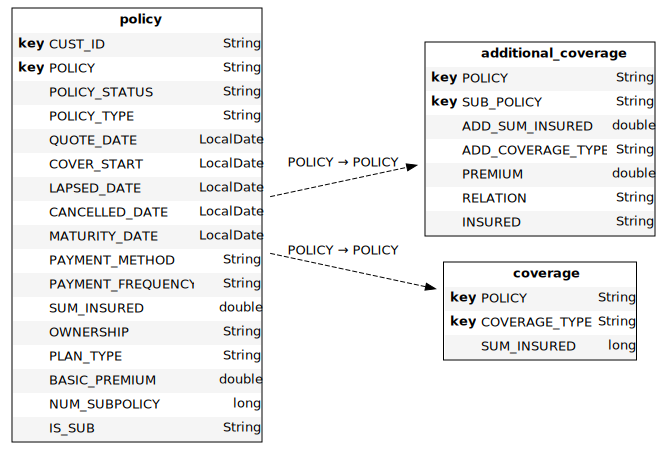

In [16]:
cube = session.create_cube(policy_tbl, "Insurance")
cube.schema

We will be able start creating visualizations based on the data schema that we have.  
The below pivot table allows us to have a quick view on the status of the policies that each customer has.

In [17]:
session.visualize("Policy overview by customers")

Open the notebook in JupyterLab with the atoti extension enabled to build this widget.

### Enriching cube with customer table

Finally, we can enrich the cube with client information:

In [18]:
customer_tbl = session.read_sql(
    "select CUST_ID ,DATE(DOB) as DOB, AGE_IN_YEARS(DOB::DATE) as AGE, EMPLOYMENT_STATUS,MARITAL_STATUS,GENDER,STATE,CITY,INCOME,EDUCATION from client;",
    url="jdbc:vertica://192.168.56.101:5433/VMart?user=dbadmin&password=password",
    table_name="customer",
    keys=["CUST_ID", "AGE"],
    driver="com.vertica.jdbc.Driver",
)

In [19]:
customer_tbl.head()

DOB EMPLOYMENT_STATUS    MARITAL_STATUS  GENDER STATE  \
CUST_ID   AGE                                                                
C00000008 48  1973-12-20          Employed             Other  Neuter   QLD   
C00000028 31  1991-03-11     Self-employed  Domestic partner  Female   QLD   
C00000040 32  1989-12-18     Self-employed  Domestic partner  Female   TAS   
C00000044 47  1975-04-13          Employed  Domestic partner  Female   VIC   
C00000037 32  1989-12-23        Freelancer             Other    Male   QLD   

                     CITY           INCOME  \
CUST_ID   AGE                                
C00000008 48   Gold Coast  50,000 - 74,999   
C00000028 31     Brisbane  25,000 - 49,999   
C00000040 32       Hobart  50,000 - 74,999   
C00000044 47    Melbourne  50,000 - 74,999   
C00000037 32   Gold Coast  75,000 - 99,000   

                                         EDUCATION  
CUST_ID   AGE                                       
C00000008 48                     Bachelor's Degree  
C00000028 31                       Upper Secondary  
C00000040 32                       Upper Secondary  
C00000044 47   Certificate in Vocational Education  
C00000037 32   Certificate in Vocational Education

In [20]:
policy_tbl.join(customer_tbl)

### Adding analytic tables

We can enrich the cube further with information such as the longitude and latitude for the location where the clients are based in. 

In [21]:
location_tbl = session.read_csv(
    "s3://data.atoti.io/notebooks/customer360/location.csv",
    table_name="location",
    keys=["STATE", "CITY"],
)

location_tbl.head(2)

STATE_NAME    COUNTRY   LATITUDE  LONGITUDE
CITY      STATE                                                  
Newcastle NSW    New South Wales  Australia -32.916668   151.7500
Sydney    NSW    New South Wales  Australia -33.865143   151.2099

Or we can use Pandas dataframe to create a table that will give us "Age groups".

In [22]:
age_groups_tbl = session.read_pandas(
    pd.DataFrame(
        data=[("0-17Y", i) for i in range(18)]
        + [("18-64Y", i) for i in range(18, 65)]
        + [("65Y+", i) for i in range(65, 100)],
        columns=["AGE GROUP", "AGE"],
    ),
    table_name="Age_Groups",
    keys=["AGE"],
)

age_groups_tbl.head(2)

AGE GROUP
AGE          
11      0-17Y
23     18-64Y

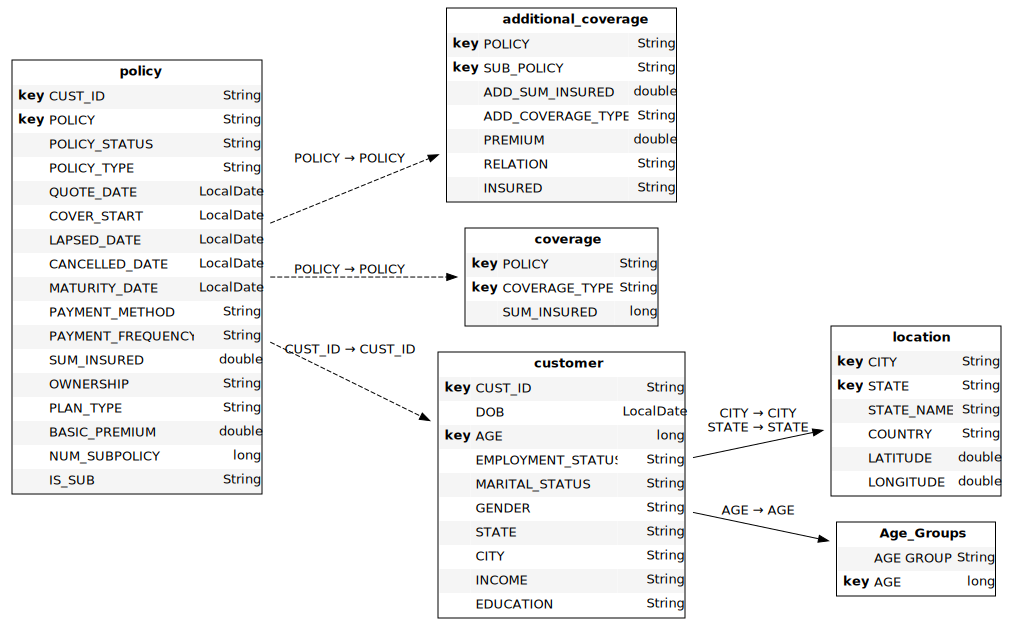

In [23]:
customer_tbl.join(age_groups_tbl)
customer_tbl.join(location_tbl)

cube.schema

### Adding policy claims

In our simplified use case, we will only look at the claims from vehicle policies.

In [24]:
claim_tbl = session.read_sql(
    "select POLICY, Date(CLAIM_DATE) as CLAIM_DATE, CLAIM_AMOUNT, CLAIM_REASON from claims;",
    url="jdbc:vertica://192.168.56.101:5433/VMart?user=dbadmin&password=password",
    table_name="claim",
    keys=["POLICY", "CLAIM_DATE"],
    driver="com.vertica.jdbc.Driver",
)

policy_tbl.join(claim_tbl)

In [25]:
claim_tbl.head()

CLAIM_AMOUNT CLAIM_REASON
POLICY  CLAIM_DATE                           
V000011 2007-09-10       3270.88         Hail
V000127 2013-02-27       4103.06    Collision
V000180 2018-05-07       3648.55    Collision
V000403 2020-04-19       4923.35        Other
V000560 2014-01-13       1282.16         Hail

### Generating timeline for policy (with exclusion of Payment module)

Keeping the notebook simple, we will exclude the payment module. However, we should still be able to perform some simple analytics to look at the increase in premiums due to newly added policies; or the decrease due to the cancellation, lapsed or maturity of existing policies.  

To do this, we create a timeline for the policies, covering the cover start date, lapsed date, cancelled date and maturity date. We will not include renewal in this use case.  
Feel free to expand on the use case.

In [26]:
timeline_tbl = session.read_sql(
    """select POLICY, TIMELINE from (
        select policy, date(cover_start) as timeline from policy_life
        union
        select policy, date(lapsed_date) as timeline from policy_life
        union
        select policy, date(cancelled_date) as timeline from policy_life
        union
        select policy, date(maturity_date) as timeline from policy_life
        ) temp
        where TIMELINE is not null;""",
    url="jdbc:vertica://192.168.56.101:5433/VMart?user=dbadmin&password=password",
    table_name="timeline",
    keys=["POLICY"],
    driver="com.vertica.jdbc.Driver",
)

We can create a Python function to load the data for each policy types.

In [27]:
def load_timeline(policy_type):
    timeline_tbl.load_sql(
        f"""select POLICY, TIMELINE from (
        select policy, date(cover_start) as timeline from policy_{policy_type}
        union
        select policy, date(lapsed_date) as timeline from policy_{policy_type}
        union
        select policy, date(cancelled_date) as timeline from policy_{policy_type}
        union
        select policy, date(maturity_date) as timeline from policy_{policy_type}
        ) temp
        where TIMELINE is not null;""",
        url="jdbc:vertica://192.168.56.101:5433/VMart?user=dbadmin&password=password",
        driver="com.vertica.jdbc.Driver",
    )

In [28]:
load_timeline("vehicle")
load_timeline("property")
timeline_tbl.head()

TIMELINE
POLICY            
L048321 2012-02-26
L024780 2007-10-20
L052716 2018-06-22
L021909 2007-04-17
L002363 1999-07-18

In [29]:
policy_tbl.join(timeline_tbl)

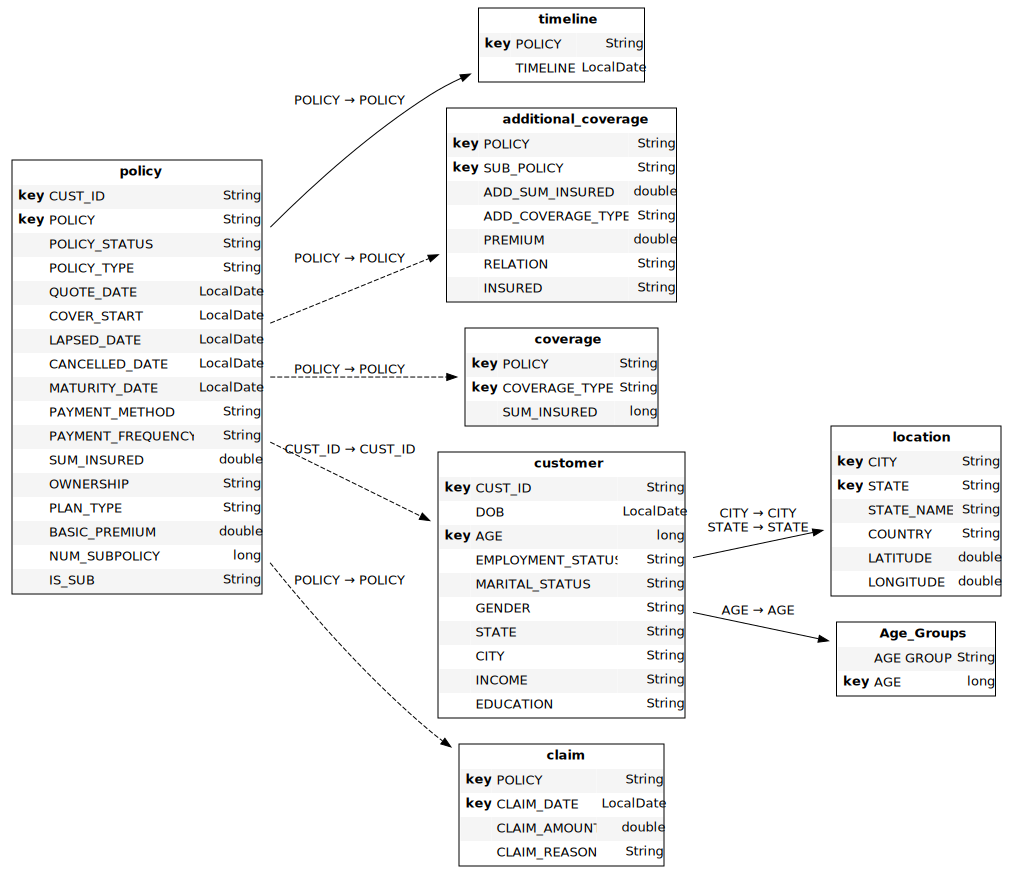

In [30]:
cube.schema

### Enabling aggregation sharing without caching

We can configure the [aggregation cache](https://docs.atoti.io/latest/lib/atoti.aggregates_cache.html#atoti.aggregates_cache.AggregatesCache.capacity) of the cube to share computation from queries if they are executed at the same time, with or without caching.

In [31]:
cube.aggregates_cache.capacity = 0

## Visualizing data in "as-is" state  

Based on what is loaded from the various data sources, we are able to start creating visuals without having to worry about the relationships between the table.  
Users will only need to know what are the hierarchies and measures that they want to explore.

In [32]:
session.visualize("Policy status by policy type")

Open the notebook in JupyterLab with the atoti extension enabled to build this widget.

The above charts give the policy status across the entire timeline of our dataset. It may seem that vehicle policies have higher cancellation rate and property policies are more likely to lapse.  

Let's add timeline to our visualization to put things into perspective. But before that, we need to create some measures to perform some aggregation.

## Manipulating hierarchies and measures

The cube has the below attributes that we will use to create our measures.

In [33]:
h, l, m = cube.hierarchies, cube.levels, cube.measures

### Create date hierarchy on the timeline

We have the timeline for the various milestones of the policy. By creating a [date hierarchy](https://docs.atoti.io/latest/lib/atoti.experimental.html#atoti.experimental.create_date_hierarchy), we can view our measures on yearly, quarterly or monthly basis.

In [34]:
cube.create_date_hierarchy(
    "Time",
    column=timeline_tbl["TIMELINE"],
    levels={"Year": "yyyy", "Quarter": "QQQ", "Month": "MM"},
)

### Creating measures  

#### Resiliation rate

We compute the resiliance rate by taking the number of lapsed and cancelled policies against the total number of policies.

In [36]:
m["Number of lapsed policies"] = tt.agg.sum(
    tt.where(l["POLICY_STATUS"] == "Lapsed", m["contributors.COUNT"]),
    scope=tt.OriginScope(
        l["POLICY_STATUS"], l["POLICY"], l["CUST_ID"], l["POLICY_TYPE"]
    ),
)

m["Number of cancelled policies"] = tt.agg.sum(
    tt.where(l["POLICY_STATUS"] == "Cancelled", m["contributors.COUNT"]),
    scope=tt.OriginScope(
        l["POLICY_STATUS"], l["POLICY"], l["CUST_ID"], l["POLICY_TYPE"]
    ),
)

m["Number of live policies"] = tt.agg.sum(
    tt.where(l["POLICY_STATUS"] == "Live", m["contributors.COUNT"]),
    scope=tt.OriginScope(
        l["POLICY_STATUS"], l["POLICY"], l["CUST_ID"], l["POLICY_TYPE"]
    ),
)

In [37]:
m["Resiliation rate"] = (
    m["Number of lapsed policies"] + m["Number of cancelled policies"]
) / m["contributors.COUNT"]
m["Resiliation rate"].formatter = "DOUBLE[#.00%]"

In [38]:
session.visualize("Resiliance rate of each policy type")

Open the notebook in JupyterLab with the atoti extension enabled to build this widget.

Putting the resiliation rate against the timeline hierarchy, we can see that property type policies are more likely to lapse than the other two policies based on the past 5 years performance. There is also an gradual increase in resiliation over the years.

In [39]:
session.visualize("Resiliation rate of each policy type for the past 5 years")

Open the notebook in JupyterLab with the atoti extension enabled to build this widget.

#### Policy durations

We can compute measures for moving dates, such as the policy duration, months from inception etc from the current date.  
The current date is derived using the [Python function datetime](https://docs.python.org/3/library/datetime.html).  

We can apply conditions to compute the durations, putting the policy status into consideration:

In [40]:
m["Policy duration"] = tt.agg.mean(
    tt.switch(
        l["POLICY_STATUS"],
        {
            "Lapsed": tt.date_diff(l["COVER_START"], l["LAPSED_DATE"], unit="years"),
            "Cancelled": tt.date_diff(
                l["COVER_START"], l["CANCELLED_DATE"], unit="years"
            ),
        },
        default=tt.date_diff(l["COVER_START"], l["MATURITY_DATE"], unit="years"),
    ),
    scope=tt.OriginScope(
        l["POLICY_STATUS"],
        l["COVER_START"],
        l["LAPSED_DATE"],
        l["CANCELLED_DATE"],
        l["MATURITY_DATE"],
        l["POLICY"],
        l["CUST_ID"],
    ),
)

m["Months from inception"] = tt.agg.mean(
    tt.switch(
        l["POLICY_STATUS"],
        {
            "Lapsed": tt.date_diff(l["COVER_START"], l["LAPSED_DATE"], unit="months"),
            "Cancelled": tt.date_diff(
                l["COVER_START"], l["CANCELLED_DATE"], unit="months"
            ),
        },
        default=tt.date_diff(l["COVER_START"], datetime.today(), unit="months"),
    ),
    scope=tt.OriginScope(
        l["POLICY_STATUS"],
        l["COVER_START"],
        l["LAPSED_DATE"],
        l["CANCELLED_DATE"],
        l["MATURITY_DATE"],
        l["POLICY"],
        l["CUST_ID"],
    ),
)

m["Policy duration"].formatter = "DOUBLE[#]"
m["Months from inception"].formatter = "DOUBLE[#]"

#### No Claims Discount (NCD)

Based on the Policy plan type and the number of years without claims, discounts are given to the policy.  
We will load the discounts configuration for vehicle policies into the cube for computation of the final premiums.

In [41]:
ncd_tbl = session.read_csv(
    "s3://data.atoti.io/notebooks/customer360/ncd.csv",
    table_name="NCD",
    keys=["POLICY_TYPE", "PLAN", "NCD_YEARS"],
)

In [42]:
ncd_tbl.head()

DISCOUNT
POLICY_TYPE PLAN              NCD_YEARS          
Vehicle     Personal Basic    1             0.100
            Personal Extended 1             0.125
            Corporate Basic   1             0.100
                              2             0.150
            Special Basic     1             0.050

We can explicitly define the join between the tables.

In [43]:
policy_tbl.join(
    ncd_tbl,
    (policy_tbl["PLAN_TYPE"] == ncd_tbl["PLAN"])
    & (policy_tbl["POLICY_TYPE"] == ncd_tbl["POLICY_TYPE"]),
)

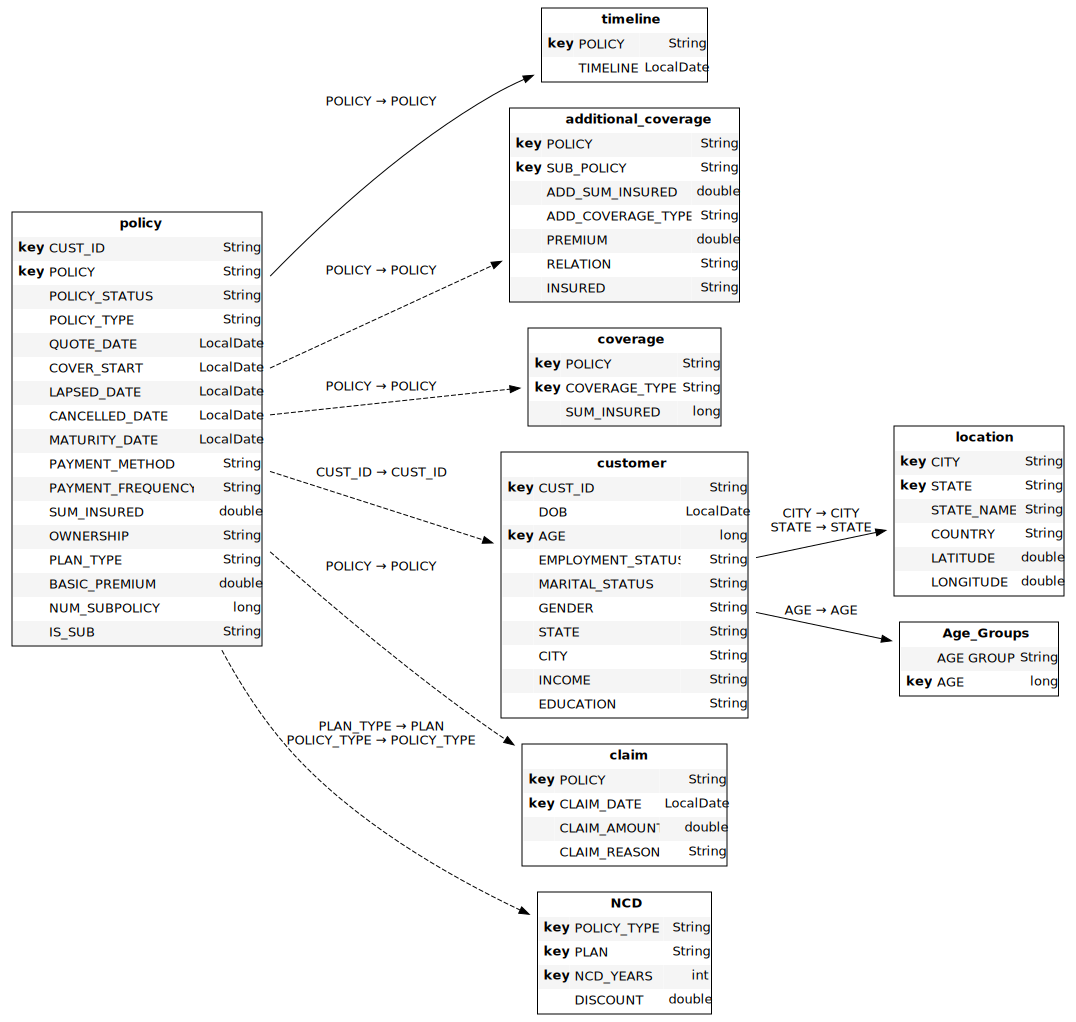

In [44]:
cube.schema

We will first compute the number of months since the last claim was made. Then we can derive the number of years without claims.  
Note that we are using the python function `datetime` to get the NCD with reference to the current date. Hence, the NCD is computed based on a moving date.

In [45]:
default_date = datetime.strptime("1970/01/01", "%Y/%d/%m").date()

In [46]:
m["Months since claim"] = tt.where(
    l["CLAIM_DATE"] == default_date,
    tt.date_diff(l["COVER_START"], datetime.today(), unit="months"),
    tt.date_diff(l["CLAIM_DATE"], datetime.today(), unit="months"),
)
m["Last claim date"] = tt.where(
    l["CLAIM_DATE"] == default_date,
    tt.agg.min_member(m["Months since claim"], l["COVER_START"]),
    tt.agg.min_member(m["Months since claim"], l["CLAIM_DATE"]),
)

m["Months since last claims"] = tt.date_diff(
    m["Last claim date"],
    datetime.today(),
    unit="months",
)

m["Policy NCD"] = tt.agg.min(
    tt.math.floor(m["Months since last claims"] / 12),
    scope=tt.OriginScope(l["POLICY"], l["CLAIM_DATE"], l["COVER_START"]),
)

We will take the most recent claim to compute the NCD period for the policy.

In [47]:
session.visualize("Period since last claims")

Open the notebook in JupyterLab with the atoti extension enabled to build this widget.

Note that there is a max number of years for the NCD. Beyond this number of years, the amount of discount given is the same.  
We will get the max NCD period for each of the policy plan.

In [48]:
m["NCD Years"] = tt.where(
    (~l["NCD_YEARS"].isnull()) & (~l["PLAN_TYPE"].isnull()),
    tt.agg.single_value(ncd_tbl["NCD_YEARS"]),
)

m["Max NCD Year"] = tt.agg.mean(
    tt.agg.max(m["NCD Years"], scope=tt.SiblingsScope(hierarchy=h["NCD_YEARS"])),
    scope=tt.OriginScope(l["PLAN_TYPE"], l["POLICY"]),
)

As the NCD discounts are in the referenced table, we will need to create a measure for it manually.

In [49]:
m["NCD Disounts"] = tt.agg.mean(ncd_tbl["DISCOUNT"])

We apply the discount depending on the number of NCD years the policy has. Otherwise, no discount is given.

In [50]:
m["Applied discount"] = tt.agg.mean(
    tt.where(
        (m["Policy NCD"] >= m["Max NCD Year"]) & (m["Max NCD Year"] == l["NCD_YEARS"])
        | (l["NCD_YEARS"] == m["Policy NCD"]),
        m["NCD Disounts"],
        0,
    ),
    scope=tt.OriginScope(l["NCD_YEARS"]),
)

m["Applied discount"].formatter = "DOUBLE[#.000%]"

We will aggregate the premiums after applying the discount. For all other insurances without NCD, we will take the value of the basic premium.

In [51]:
m["Discounted premium"] = tt.agg.sum(
    tt.agg.sum(
        tt.where(
            l["NCD_YEARS"] == 0,
            m["BASIC_PREMIUM.SUM"],
            tt.where(
                (m["Applied discount"] != 0),
                (1 - m["Applied discount"]) * m["BASIC_PREMIUM.SUM"],
            ),
        ),
        scope=tt.OriginScope(l["NCD_YEARS"]),
    ),
    scope=tt.OriginScope(l["POLICY"]),
)

In [52]:
session.visualize("Computation of premiums after NCD")

Open the notebook in JupyterLab with the atoti extension enabled to build this widget.

#### Claims

In this use case, we only have the claim information for vehicle type policies.

In [53]:
m["Claim Amount"] = tt.agg.sum(
    tt.agg.single_value(claim_tbl["CLAIM_AMOUNT"]),
    scope=tt.OriginScope(l["POLICY"], l["CLAIM_DATE"]),
)

In [54]:
session.visualize("Claim amount")

Open the notebook in JupyterLab with the atoti extension enabled to build this widget.

#### Additional coverage measures

Before we compute the total premiums and sum assured for a customer, let's create the measure for the additional coverage.

In [55]:
m["Add. coverage premium"] = tt.agg.sum(addons_tbl["PREMIUM"])
m["Add. sum insured"] = tt.agg.sum(addons_tbl["ADD_SUM_INSURED"])

In [56]:
session.visualize("Additional coverage for customer C00035686")

Open the notebook in JupyterLab with the atoti extension enabled to build this widget.

#### Computing the premium

We compute the total premium at the point of inception. This will give us some insight on the incoming premium based on the cover start date.  

Since payment frequency can be monthly, annually or 3 Yearly, we breakdown the premium to monthly denominator.

In [57]:
m["Total premium"] = m["BASIC_PREMIUM.SUM"] + m["Add. coverage premium"]

In [58]:
m["Initial total monthly premium"] = tt.agg.sum(
    tt.where(
        l["PAYMENT_FREQUENCY"] == "Annual",
        m["Total premium"] / 12,
        tt.where(
            l["PAYMENT_FREQUENCY"] == "3 Years",
            m["Total premium"] / 36,
            tt.where(l["PAYMENT_FREQUENCY"] == "Month", m["Total premium"]),
        ),
    ),
    scope=tt.OriginScope(l["PAYMENT_FREQUENCY"]),
)

From the below chart, we can see that amount of premium coming in from new policies (growth only).  
However, this value may change for various reasons, e.g.:
- Premium for Life insurance may increase 8% to 10% for every year of age;
- Premium of Vehicle insurance may decrease with NCD  

In [59]:
session.visualize("Monthly premium based on new policies cover start date")

Open the notebook in JupyterLab with the atoti extension enabled to build this widget.

Let's take into consideration the NCD discounts as of the current status of the premium to see how much has changed:

In [60]:
m["Total discounted premium"] = m["Discounted premium"] + m["Add. coverage premium"]

In [61]:
m["Current total monthly premium"] = tt.agg.sum(
    tt.where(
        l["PAYMENT_FREQUENCY"] == "Annual",
        m["Total discounted premium"] / 12,
        tt.where(
            l["PAYMENT_FREQUENCY"] == "3 Years",
            m["Total discounted premium"] / 36,
            tt.where(l["PAYMENT_FREQUENCY"] == "Month", m["Total discounted premium"]),
        ),
    ),
    scope=tt.OriginScope(l["PAYMENT_FREQUENCY"]),
)

In [62]:
m["Change in premium"] = (
    m["Initial total monthly premium"] - m["Current total monthly premium"]
)

In [63]:
session.visualize("Change in premium from inception till now")

Open the notebook in JupyterLab with the atoti extension enabled to build this widget.

## Exploring customer demographics  

We can look at the demographics of the customer by their age groups, income or location.

In [68]:
m["Customer count"] = tt.agg.count_distinct(customer_tbl["CUST_ID"])

In [69]:
session.visualize("Policy status by age group")

Open the notebook in JupyterLab with the atoti extension enabled to build this widget.

In [70]:
session.visualize("Sum insured across Australia")

Open the notebook in JupyterLab with the atoti extension enabled to build this widget.

### Toggling between measure and hierarchy

There are instances when a data column is useful as a hierarchy or as a measure. 

#### Hierarchy to measure - Age exploration

Let's look at `AGE` from the `Age_Groups` and `customer` tables for instance.  

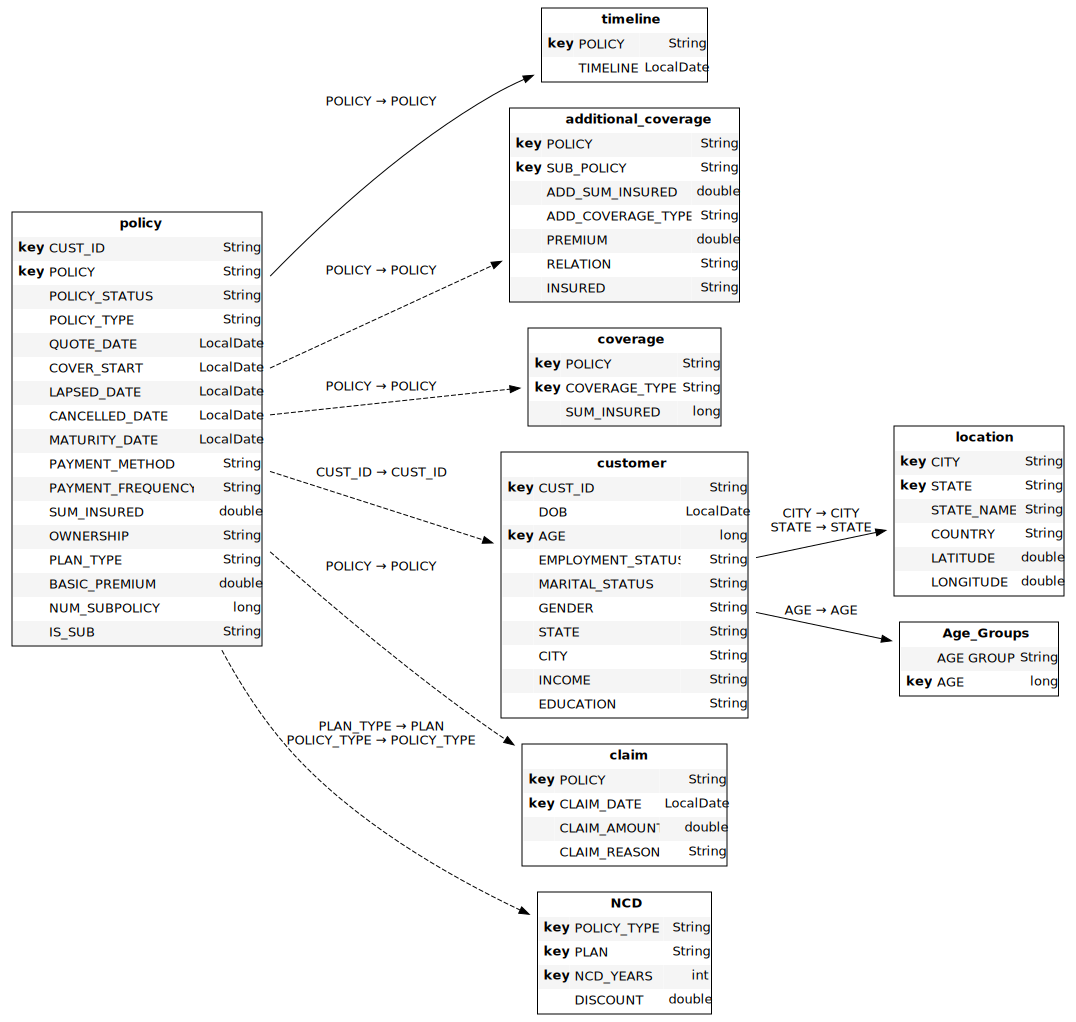

In [71]:
cube.schema


Atoti automatically creates as a hierarchy since the `AGE` column is the key of a table.  
However, that doesn't stop us from using it as a measure. Simply create the measure by aggregating the column from the table.

In [72]:
m["age"] = tt.agg.mean(customer_tbl["AGE"])

We can see from the below chart, people from the 25-65 age range is more likely to cancel their policies and generally within the first 15 years from inception.

In [73]:
session.visualize("Duration of cancelled policy by age")

Open the notebook in JupyterLab with the atoti extension enabled to build this widget.

It is also worthy to note that the age range has the most buying power and forms the majority of the policyholders.

In [74]:
session.visualize("No. of policies by age")

Open the notebook in JupyterLab with the atoti extension enabled to build this widget.

#### Measure to Hierarchy - Additional coverage take up rate

Some insurance, such as the property policies, can have optional add-on coverages that contribute towards the final premium. 

In [75]:
h["No. sub policy"] = [policy_tbl["NUM_SUBPOLICY"]]

Close to 70% of the property type policies do not have add-on coverage while approximately 15% have either 1 or 2 add-ons.

In [76]:
session.visualize("Number of add-on coverage for property policies")

Open the notebook in JupyterLab with the atoti extension enabled to build this widget.

## Dashboarding

In [77]:
session.link(path="/#/dashboard/03f")

Open the notebook in JupyterLab with the atoti extension enabled to see this link.

Draw insights based on the customers' demographics or interactively select customers to see the details of their policies.

<img src="customer_360.gif" alt="Customer 360">

<div style="text-align: center;" ><a href="https://www.atoti.io/?utm_source=gallery&utm_content=customer360" target="_blank" rel="noopener noreferrer"><img src="https://data.atoti.io/notebooks/banners/Your-turn-to-try-Atoti.jpg" alt="Try Atoti"></a></div>